In [1]:
import itertools
import networkx as nx

# -----------------------------
# Parameters
# -----------------------------
N = 5  # number of drones/nodes
kappa = 1.0   # per-link crosstalk coefficient
gamma = 1.0   # per-node crosstalk coefficient
MAX_REPEATERS = 2  # "at most 2 repeaters" rule

# -----------------------------
# Helper functions
# -----------------------------
def build_topology(name):
    """Return a NetworkX Graph for given topology name."""
    G = nx.Graph()
    G.add_nodes_from(range(1, N + 1))
    if name == "Bus":
        edges = [(i, i + 1) for i in range(1, N)]
    elif name == "Ring":
        edges = [(i, i + 1) for i in range(1, N)] + [(N, 1)]
    elif name == "Star":
        hub = 1
        edges = [(hub, i) for i in range(2, N + 1)]
    elif name == "Mesh":
        edges = list(itertools.combinations(range(1, N + 1), 2))
    else:
        raise ValueError(f"Unknown topology {name}")
    G.add_edges_from(edges)
    return G

def count_crosstalk(G):
    """Compute normalized crosstalk_strength for all-pairs sessions."""
    sessions = list(itertools.combinations(G.nodes, 2))
    edge_loads = {e: 0 for e in G.edges}
    node_loads = {n: 0 for n in G.nodes}

    for u, v in sessions:
        path = nx.shortest_path(G, u, v)
        repeaters = path[1:-1]
        if len(repeaters) > MAX_REPEATERS:
            repeaters = repeaters[:MAX_REPEATERS]
        # Count edge usage
        for e in zip(path, path[1:]):
            e_sorted = tuple(sorted(e))
            edge_loads[e_sorted] += 1
        # Count node (repeater) usage
        for n in repeaters:
            node_loads[n] += 1

    # Raw crosstalk
    edge_term = sum(kappa * (L * (L - 1) / 2) for L in edge_loads.values())
    node_term = sum(gamma * (B * (B - 1) / 2) for B in node_loads.values())
    raw_crosstalk = edge_term + node_term

    # Max possible crosstalk (if all sessions go through same link + repeaters)
    max_edge_load = len(sessions)  # all pairs on same link
    max_node_load = len(sessions)  # all pairs through same repeater
    max_crosstalk = kappa * (max_edge_load * (max_edge_load - 1) / 2) \
                    + gamma * (max_node_load * (max_node_load - 1) / 2)

    # Normalize between 0 and 1
    norm_crosstalk = raw_crosstalk / max_crosstalk if max_crosstalk > 0 else 0
    return norm_crosstalk, edge_loads, node_loads

# -----------------------------
# Run for all topologies
# -----------------------------
topologies = ["Bus", "Ring", "Star", "Mesh"]
results = {}

for topo in topologies:
    G = build_topology(topo)
    norm_crosstalk, edge_loads, node_loads = count_crosstalk(G)
    results[topo] = norm_crosstalk
    print(f"=== {topo} ===")
    print("Edges:", list(G.edges))
    print("Edge loads:", edge_loads)
    print("Node loads:", node_loads)
    print(f"Crosstalk Strength (0–1) = {norm_crosstalk:.3f}")
    print()

# -----------------------------
# Summary ranking
# -----------------------------
print("=== Crosstalk Strength Ranking (0–1) ===")
for topo, score in sorted(results.items(), key=lambda x: x[1]):
    print(f"{topo}: {score:.3f}")


=== Bus ===
Edges: [(1, 2), (2, 3), (3, 4), (4, 5)]
Edge loads: {(1, 2): 4, (2, 3): 6, (3, 4): 6, (4, 5): 4}
Node loads: {1: 0, 2: 3, 3: 4, 4: 2, 5: 0}
Crosstalk Strength (0–1) = 0.578

=== Ring ===
Edges: [(1, 2), (1, 5), (2, 3), (3, 4), (4, 5)]
Edge loads: {(1, 2): 3, (1, 5): 3, (2, 3): 3, (3, 4): 3, (4, 5): 3}
Node loads: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1}
Crosstalk Strength (0–1) = 0.167

=== Star ===
Edges: [(1, 2), (1, 3), (1, 4), (1, 5)]
Edge loads: {(1, 2): 4, (1, 3): 4, (1, 4): 4, (1, 5): 4}
Node loads: {1: 6, 2: 0, 3: 0, 4: 0, 5: 0}
Crosstalk Strength (0–1) = 0.433

=== Mesh ===
Edges: [(1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]
Edge loads: {(1, 2): 1, (1, 3): 1, (1, 4): 1, (1, 5): 1, (2, 3): 1, (2, 4): 1, (2, 5): 1, (3, 4): 1, (3, 5): 1, (4, 5): 1}
Node loads: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
Crosstalk Strength (0–1) = 0.000

=== Crosstalk Strength Ranking (0–1) ===
Mesh: 0.000
Ring: 0.167
Star: 0.433
Bus: 0.578


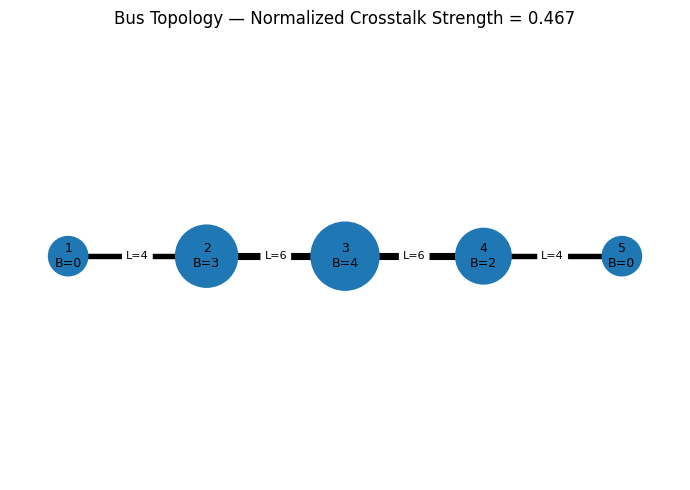

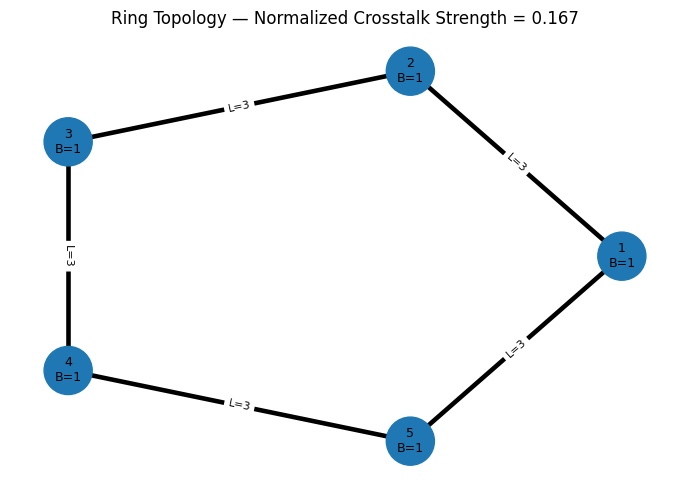

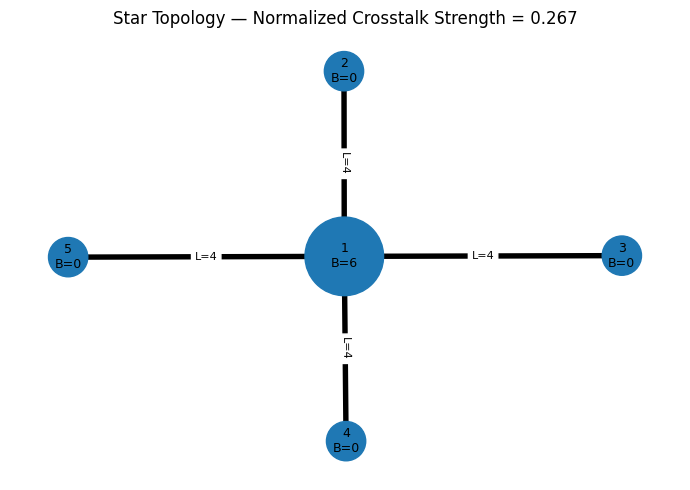

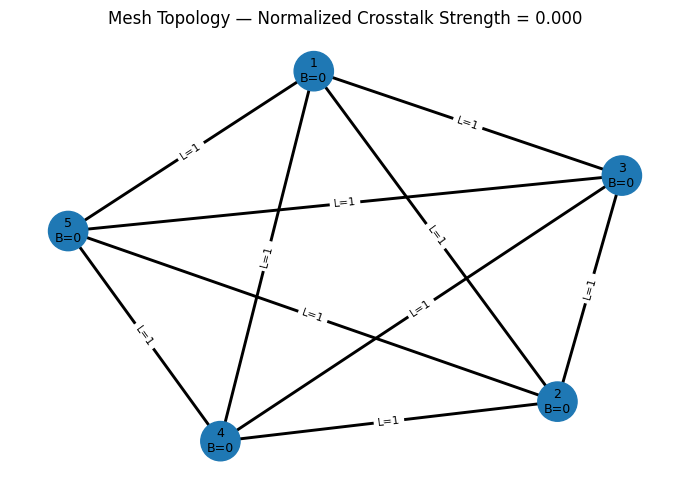

(['/mnt/data/qiod_figures\\bus_qiod_loads.png',
  '/mnt/data/qiod_figures\\ring_qiod_loads.png',
  '/mnt/data/qiod_figures\\star_qiod_loads.png',
  '/mnt/data/qiod_figures\\mesh_qiod_loads.png'],
 '/mnt/data/qiod_figures\\summary.txt')

In [2]:
# QIoD Crosstalk: visualize loads for Bus, Ring, Star, Mesh
# - Computes edge loads (L_e) and node loads (B_n) for all-pairs teleportation sessions
# - Enforces at most 2 repeaters per path (by truncation -> models scheduling)
# - Draws one figure per topology with:
#     * node sizes proportional to B_n (repeater load)
#     * edge widths proportional to L_e (link load)
#     * edge labels showing L_e
#     * node labels "id\nB=.." showing B_n
#
# Files are saved to /mnt/data so you can download them.
import itertools
import os
import math
from typing import Dict, Tuple, List

import matplotlib.pyplot as plt
import networkx as nx

# -----------------------------
# Parameters
# -----------------------------
N = 5  # number of drones/nodes
kappa = 1.0   # per-link crosstalk coefficient
gamma = 1.0   # per-node crosstalk coefficient
MAX_REPEATERS = 2  # "at most 2 repeaters" rule

out_dir = "/mnt/data/qiod_figures"
os.makedirs(out_dir, exist_ok=True)

# -----------------------------
# Helper functions
# -----------------------------
def build_topology(name: str) -> nx.Graph:
    """Return a NetworkX Graph for given topology name."""
    G = nx.Graph()
    G.add_nodes_from(range(1, N + 1))
    if name == "Bus":
        edges = [(i, i + 1) for i in range(1, N)]
    elif name == "Ring":
        edges = [(i, i + 1) for i in range(1, N)] + [(N, 1)]
    elif name == "Star":
        hub = 1
        edges = [(hub, i) for i in range(2, N + 1)]
    elif name == "Mesh":
        edges = list(itertools.combinations(range(1, N + 1), 2))
    else:
        raise ValueError(f"Unknown topology {name}")
    G.add_edges_from(edges)
    return G

def compute_loads(G: nx.Graph):
    """Compute edge and node loads for all-pairs sessions with <=2 repeaters per path."""
    sessions = list(itertools.combinations(G.nodes, 2))
    edge_loads: Dict[Tuple[int,int], int] = {tuple(sorted(e)): 0 for e in G.edges}
    node_loads: Dict[int, int] = {n: 0 for n in G.nodes}

    for u, v in sessions:
        path = nx.shortest_path(G, u, v)
        repeaters = path[1:-1]
        # Enforce "at most 2 repeaters concurrently" by truncating counted repeaters
        if len(repeaters) > MAX_REPEATERS:
            repeaters = repeaters[:MAX_REPEATERS]
        for e in zip(path, path[1:]):
            e_sorted = tuple(sorted(e))
            edge_loads[e_sorted] += 1
        for n in repeaters:
            node_loads[n] += 1

    # Raw crosstalk
    edge_term = sum(kappa * (L * (L - 1) / 2) for L in edge_loads.values())
    node_term = sum(gamma * (B * (B - 1) / 2) for B in node_loads.values())
    raw = edge_term + node_term
    raw = edge_term 

    # Normalization: worst-case if all sessions collide on the same link and same repeater
    S = len(sessions)
    max_crosstalk = kappa * (S * (S - 1) / 2) + gamma * (S * (S - 1) / 2)
    norm = raw / max_crosstalk if max_crosstalk > 0 else 0.0
    return edge_loads, node_loads, raw, norm

def draw_topology(name: str, G: nx.Graph, edge_loads: Dict[Tuple[int,int], int], node_loads: Dict[int,int], norm_score: float, filename: str):
    """Draw a single topology with loads visualized."""
    # Node sizes proportional to B_n (min size baseline)
    B_vals = [node_loads[n] for n in G.nodes]
    if B_vals:
        maxB = max(B_vals)
    else:
        maxB = 0
    # Scale node sizes: baseline 800, add 400 per unit load
    node_sizes = [800 + 400 * (node_loads[n]) for n in G.nodes]

    # Edge widths proportional to L_e (min width 1.5)
    widths = []
    for e in G.edges:
        L = edge_loads[tuple(sorted(e))]
        widths.append(1.5 + 0.6 * L)

    # Edge labels as L_e
    edge_labels = {e: f"L={edge_loads[tuple(sorted(e))]}" for e in G.edges}

    # Node labels include B_n
    node_labels = {n: f"{n}\nB={node_loads[n]}" for n in G.nodes}

    # Layouts per topology for readability
    if name == "Bus":
        pos = {i+1: (i, 0) for i in range(N)}
    elif name == "Ring":
        pos = nx.circular_layout(G)
    elif name == "Star":
        pos = nx.spring_layout(G, seed=7)
    elif name == "Mesh":
        pos = nx.spring_layout(G, seed=3)
    else:
        pos = nx.spring_layout(G, seed=1)

    plt.figure(figsize=(7, 5))
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes)
    nx.draw_networkx_edges(G, pos, width=widths)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=9)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title(f"{name} Topology — Normalized Crosstalk Strength = {norm_score:.3f}")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(filename, dpi=200)
    plt.show()

# -----------------------------
# Generate all figures
# -----------------------------
topologies = ["Bus", "Ring", "Star", "Mesh"]
saved_files: List[str] = []
summary_lines: List[str] = []

for topo in topologies:
    G = build_topology(topo)
    edge_loads, node_loads, raw, norm = compute_loads(G)
    fname = os.path.join(out_dir, f"{topo.lower()}_qiod_loads.png")
    draw_topology(topo, G, edge_loads, node_loads, norm, fname)
    saved_files.append(fname)

    # Prepare a brief textual summary for each topology
    elist = ", ".join([f"{e}:{edge_loads[tuple(sorted(e))]}" for e in G.edges])
    nlist = ", ".join([f"{n}:{node_loads[n]}" for n in G.nodes])
    summary_lines.append(f"{topo}: norm={norm:.3f} | Edge loads [{elist}] | Node loads [{nlist}]")

# Save a text summary next to the figures
summary_path = os.path.join(out_dir, "summary.txt")
with open(summary_path, "w") as f:
    for line in summary_lines:
        f.write(line + "\n")

(saved_files, summary_path)


In [3]:
import os
import networkx as nx
import matplotlib.pyplot as plt

# Function to create topologies with repeaters
def create_topologies_with_repeaters(num_drones=5, max_repeaters=2):
    nodes = [f"D{i+1}" for i in range(num_drones)]
    repeaters = [f"R{i+1}" for i in range(max_repeaters)]
    
    topologies = {}

    # Bus topology (linear chain)
    bus_nodes = nodes.copy()
    if max_repeaters > 0:
        bus_nodes.insert(len(bus_nodes)//2, repeaters[0])
    if max_repeaters > 1:
        bus_nodes.insert(len(bus_nodes)//2 + 2, repeaters[1])
    G_bus = nx.Graph()
    for i in range(len(bus_nodes) - 1):
        G_bus.add_edge(bus_nodes[i], bus_nodes[i+1])
    topologies["Bus"] = G_bus

    # Ring topology
    G_ring = G_bus.copy()
    last_node = list(G_ring.nodes)[-1]
    first_node = list(G_ring.nodes)[0]
    G_ring.add_edge(last_node, first_node)
    topologies["Ring"] = G_ring

    # Star topology
    G_star = nx.Graph()
    center = "R1" if max_repeaters > 0 else nodes[0]
    for n in nodes:
        if n != center:
            G_star.add_edge(center, n)
    topologies["Star"] = G_star

    # Mesh topology (full connection between all)
    mesh_nodes = nodes + repeaters[:max_repeaters]
    G_mesh = nx.Graph()
    for i in range(len(mesh_nodes)):
        for j in range(i+1, len(mesh_nodes)):
            G_mesh.add_edge(mesh_nodes[i], mesh_nodes[j])
    topologies["Mesh"] = G_mesh

    return topologies

# Plotting function with nodes & repeaters
def plot_topologies_with_repeaters(topologies, save_dir="qiod_figures_with_repeaters"):
    os.makedirs(save_dir, exist_ok=True)
    positions = {}
    for name, G in topologies.items():
        plt.figure(figsize=(6, 4))
        pos = nx.spring_layout(G, seed=42)
        colors = ["orange" if "R" in node else "skyblue" for node in G.nodes()]
        nx.draw(G, pos, with_labels=True, node_color=colors, node_size=1000, font_size=10, font_weight="bold", edge_color="gray")
        plt.title(f"{name} Topology (QIoD)", fontsize=14)
        plt.savefig(os.path.join(save_dir, f"{name.lower()}_qiod_with_repeaters.png"))
        plt.close()
    return save_dir

# Generate and plot
topos_with_repeaters = create_topologies_with_repeaters(num_drones=5, max_repeaters=2)
save_dir = plot_topologies_with_repeaters(topos_with_repeaters)
save_dir


'qiod_figures_with_repeaters'